In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

virtualenv.cli_run(["venvs/time_series_downloader", "--no-download"])

venv_dir = "venvs/time_series_downloader"
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (time_series_downloader)"
kernel_name = "time_series_downloader"

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [1]:
import sys
print(sys.executable)

/workspace/data_processing/venvs/time_series_downloader/bin/python


In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

# Установка
subprocess.check_call([pip_path, "install", "tinkoff-investments", "pandas", "matplotlib"])

## Загрузка данных

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tinkoff.invest import RequestError, Quotation, Client, CandleInterval
from tinkoff.invest.utils import now
from datetime import datetime

In [4]:
T_TOKEN = os.environ.get("T_TOKEN")

In [8]:
def convert_quotation_to_float(units: int, nano: int):
    return units + (nano / (10 ** 9))


def get_instruments_ids(tickers):
  instruments_ids = {}
  with Client(T_TOKEN) as client:
    for method in ['shares']:
        for item in getattr(client.instruments, method)().instruments:
            if item.ticker in tickers:
              instruments_ids[item.ticker] = item.uid
  return instruments_ids


def get_candles(instrument_id, from_date, to_date, candle_interval):
  """
  Функция для получения свечей акции по тикеру и дате.
  :param instrument_id: Индетификатор акции
  :param date: Дата в формате datetime
  :param candle_interval: Интервал свечей
  :return: Цена акции
  """
  with Client(T_TOKEN) as client:
    candels = client.market_data.get_candles(
        instrument_id=instrument_id,
        from_=from_date,
        to=to_date,
        interval=candle_interval
    ).candles

    return candels

In [9]:
tickers = ['MOEX', 'SBER', 'LKOH', 'YDEX', 'X5', 'VTBR', 'NVTK', 'PIKK', 'AFLT', 'VKCO']
instuments_ids = get_instruments_ids(tickers)
instuments_ids

{'VKCO': 'b71bd174-c72c-41b0-a66f-5f9073e0d1f5',
 'VTBR': '8e2b0325-0292-4654-8a18-4f63ed3b0e09',
 'X5': '0964acd0-e2cb-4810-a177-ef4ad8856ff0',
 'NVTK': '0da66728-6c30-44c4-9264-df8fac2467ee',
 'MOEX': '5e1c2634-afc4-4e50-ad6d-f78fc14a539a',
 'PIKK': '03d5e771-fc10-438e-8892-85a40733612d',
 'YDEX': '7de75794-a27f-4d81-a39b-492345813822',
 'AFLT': '1c69e020-f3b1-455c-affa-45f8b8049234',
 'SBER': 'e6123145-9665-43e0-8413-cd61b8aa9b13',
 'LKOH': '02cfdf61-6298-4c0f-a9ca-9cabc82afaf3'}

In [11]:
candels = {}
for ticker, instuments_id in instuments_ids.items():
  candels[ticker] = get_candles(instuments_id, datetime(2016, 1, 1), datetime(2021, 1, 1), CandleInterval.CANDLE_INTERVAL_DAY)
  candels[ticker].extend(get_candles(instuments_id, datetime(2021, 1, 1), datetime(2025, 5, 1), CandleInterval.CANDLE_INTERVAL_DAY))
candels['MOEX'][:5]

[HistoricCandle(open=Quotation(units=93, nano=650000000), high=Quotation(units=94, nano=260000000), low=Quotation(units=91, nano=400000000), close=Quotation(units=91, nano=400000000), volume=387147, time=datetime.datetime(2016, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), is_complete=True, candle_source=<CandleSource.CANDLE_SOURCE_EXCHANGE: 1>),
 HistoricCandle(open=Quotation(units=91, nano=320000000), high=Quotation(units=91, nano=850000000), low=Quotation(units=90, nano=120000000), close=Quotation(units=91, nano=850000000), volume=323393, time=datetime.datetime(2016, 1, 4, 0, 0, tzinfo=datetime.timezone.utc), is_complete=True, candle_source=<CandleSource.CANDLE_SOURCE_EXCHANGE: 1>),
 HistoricCandle(open=Quotation(units=91, nano=830000000), high=Quotation(units=94, nano=470000000), low=Quotation(units=91, nano=810000000), close=Quotation(units=94, nano=300000000), volume=492328, time=datetime.datetime(2016, 1, 5, 0, 0, tzinfo=datetime.timezone.utc), is_complete=True, candle_source=<Cand

In [18]:
df = {}
for ticker, candles in candels.items():
  df[ticker] = pd.DataFrame([{
      'timestamp': candle.time,
      'open': convert_quotation_to_float(candle.open.units, candle.open.nano),
      'close': convert_quotation_to_float(candle.close.units, candle.close.nano),
      'high': convert_quotation_to_float(candle.high.units, candle.high.nano),
      'low': convert_quotation_to_float(candle.low.units, candle.low.nano),
      'volume': candle.volume
  } for candle in candles])

df['MOEX'].head()

,timestamp,open,close,high,low,volume
0,2016-01-01 00:00:00+00:00,93.65,91.40,94.26,91.40,387147
1,2016-01-04 00:00:00+00:00,91.32,91.85,91.85,90.12,323393
2,2016-01-05 00:00:00+00:00,91.83,94.30,94.47,91.81,492328
3,2016-01-06 00:00:00+00:00,94.34,94.44,94.87,93.88,246300
4,2016-01-07 00:00:00+00:00,94.34,94.44,94.87,93.88,246300


## Очистка

In [27]:
def trim_df_from_date(df_dict, ticker: str, cutoff_date: str):
    """
    Обрезает DataFrame указанного тикера, оставляя только данные после cutoff_date (UTC-aware).

    Args:
        df_dict (dict): Словарь DataFrame по тикерам.
        ticker (str): Тикер, для которого нужно обрезать данные.
        cutoff_date (str): Дата в формате 'YYYY-MM-DD', после которой оставляются данные.

    Returns:
        None. Изменяет df_dict[ticker] по месту.
    """
    if ticker not in df_dict:
        raise ValueError(f"Тикер {ticker} не найден в словаре.")

    # Преобразуем timestamp в datetime с UTC
    df_dict[ticker]['timestamp'] = pd.to_datetime(df_dict[ticker]['timestamp'], utc=True)

    # Преобразуем cutoff_date в Timestamp с UTC
    cutoff = pd.to_datetime(cutoff_date).tz_localize('UTC')

    # Фильтрация
    df_dict[ticker] = df_dict[ticker][df_dict[ticker]['timestamp'] >= cutoff]

In [30]:
def trim_df_until_date(df_dict, ticker: str, cutoff_date: str):
    """
    Обрезает DataFrame указанного тикера, оставляя только данные до cutoff_date включительно.

    Args:
        df_dict (dict): Словарь DataFrame по тикерам.
        ticker (str): Тикер, для которого нужно обрезать данные.
        cutoff_date (str): Дата в формате 'YYYY-MM-DD', до которой нужно оставить данные (включительно).

    Returns:
        None. Модифицирует df_dict[ticker] по месту.
    """
    import pandas as pd

    if ticker not in df_dict:
        raise ValueError(f"Тикер {ticker} не найден в словаре.")

    # Преобразуем дату и столбец времени к одному временному формату (UTC-aware)
    cutoff = pd.to_datetime(cutoff_date).tz_localize('UTC')
    df_dict[ticker]['timestamp'] = pd.to_datetime(df_dict[ticker]['timestamp'], utc=True)

    # Оставляем только данные до cutoff_date включительно
    df_dict[ticker] = df_dict[ticker][df_dict[ticker]['timestamp'] <= cutoff]

In [28]:
trim_df_from_date(df, 'VTBR', '2018-07-01')

In [31]:
trim_df_until_date(df, 'X5', '2024-02-01')

## Визуализация

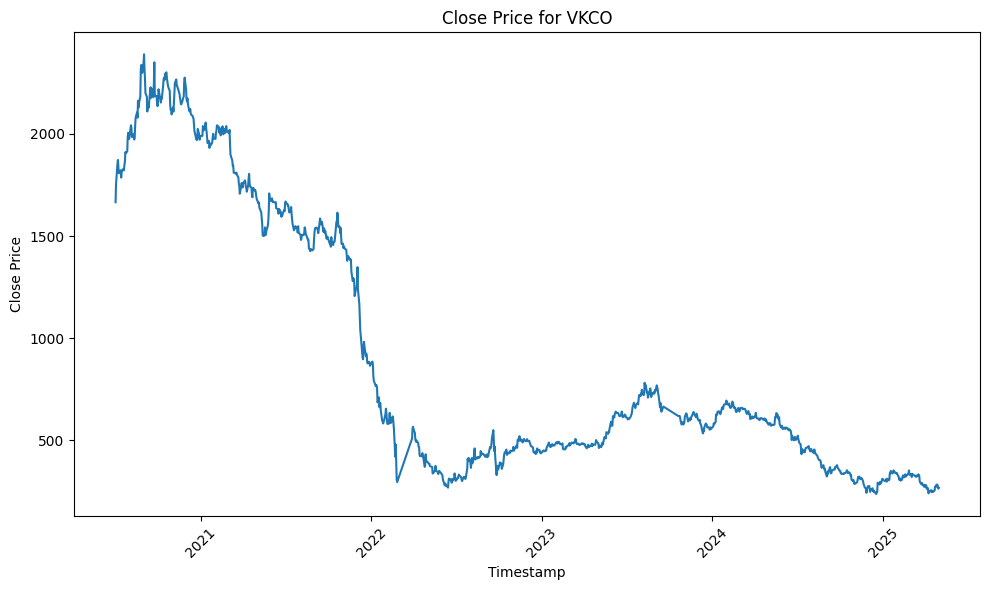

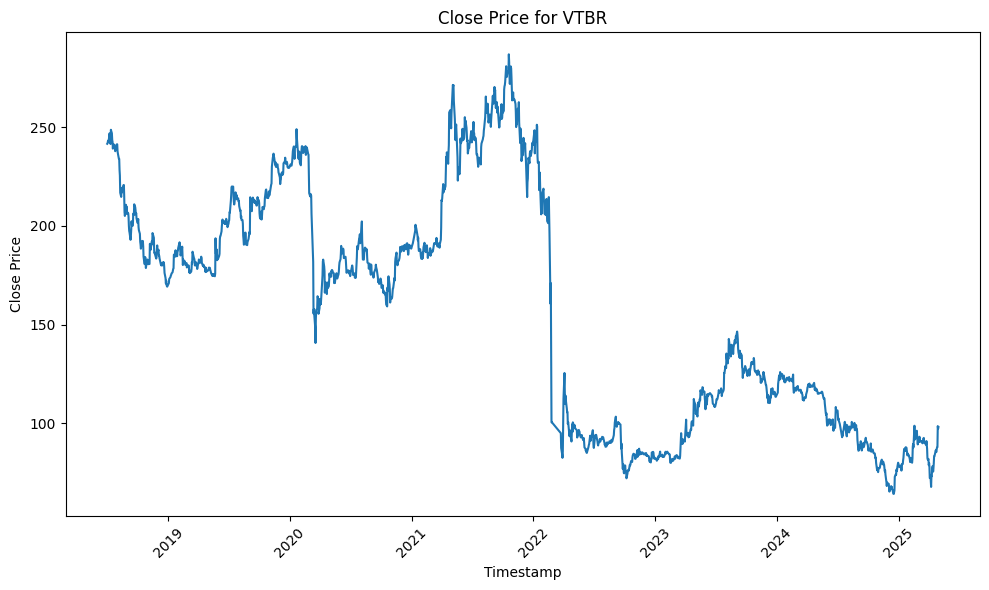

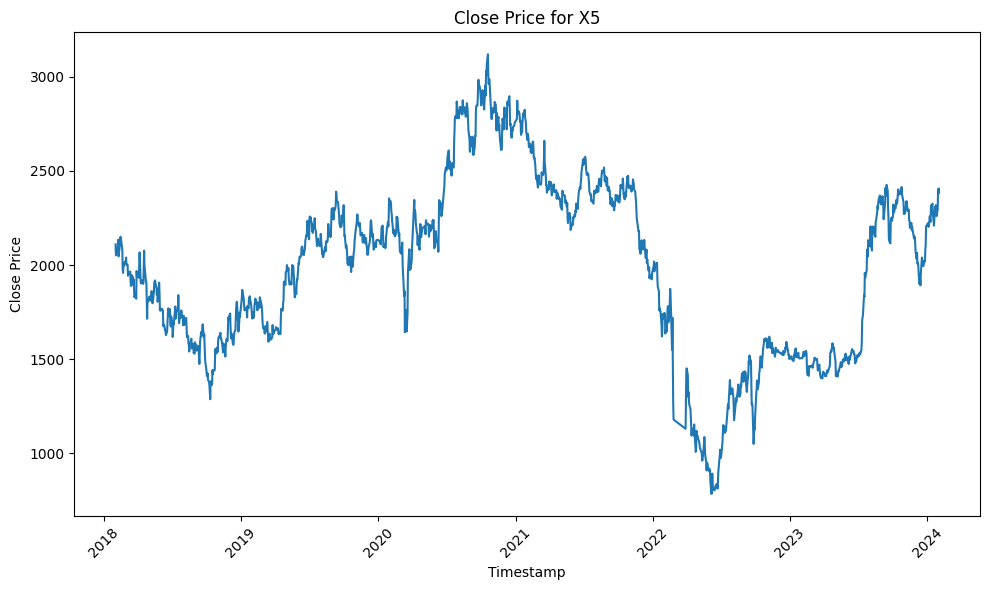

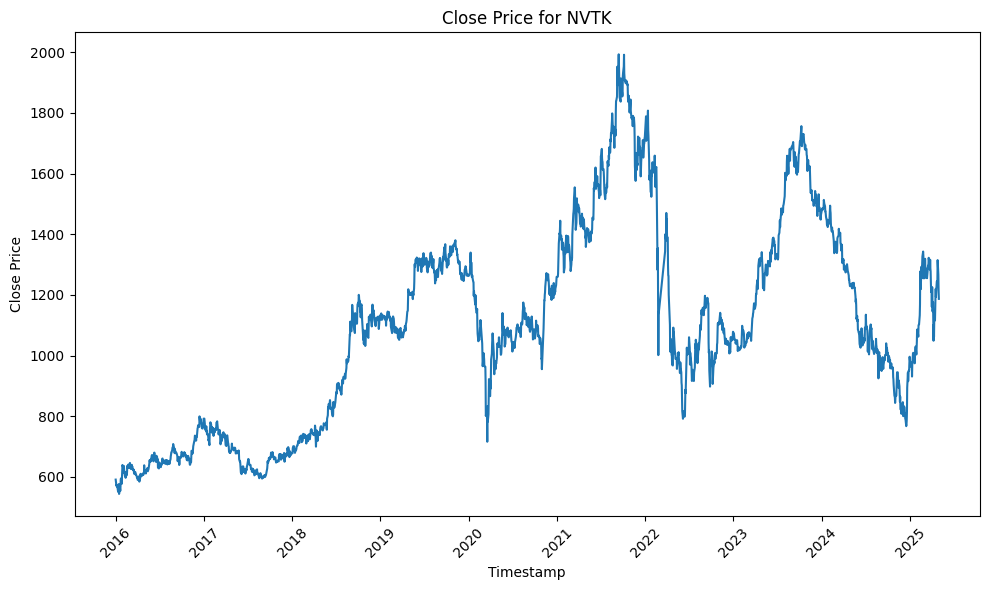

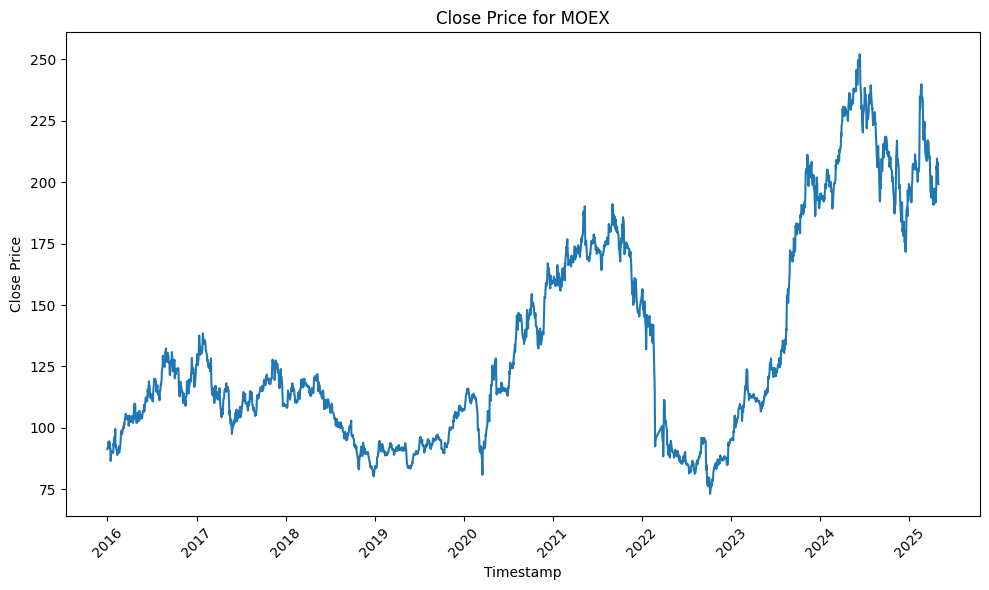

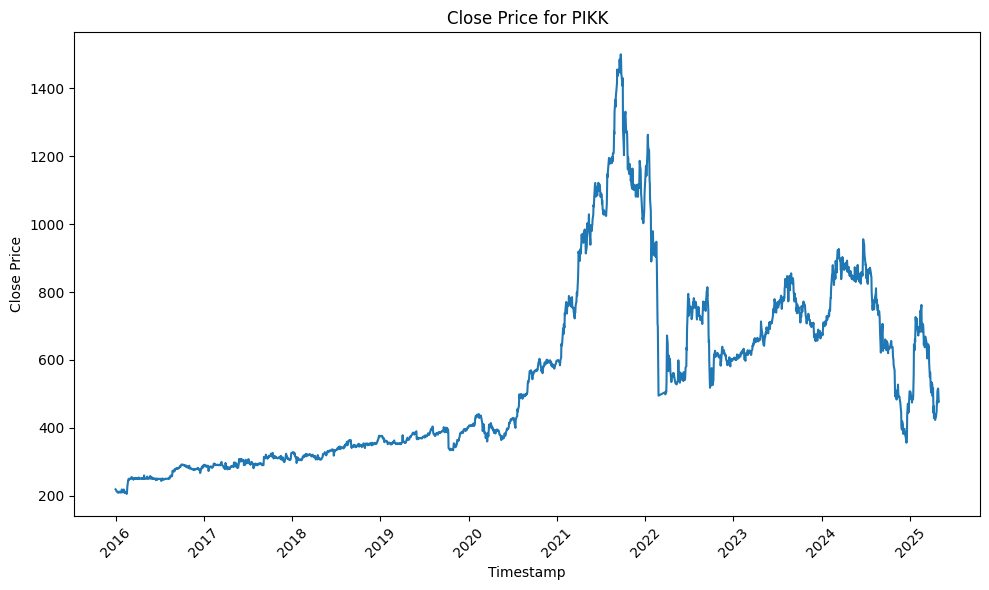

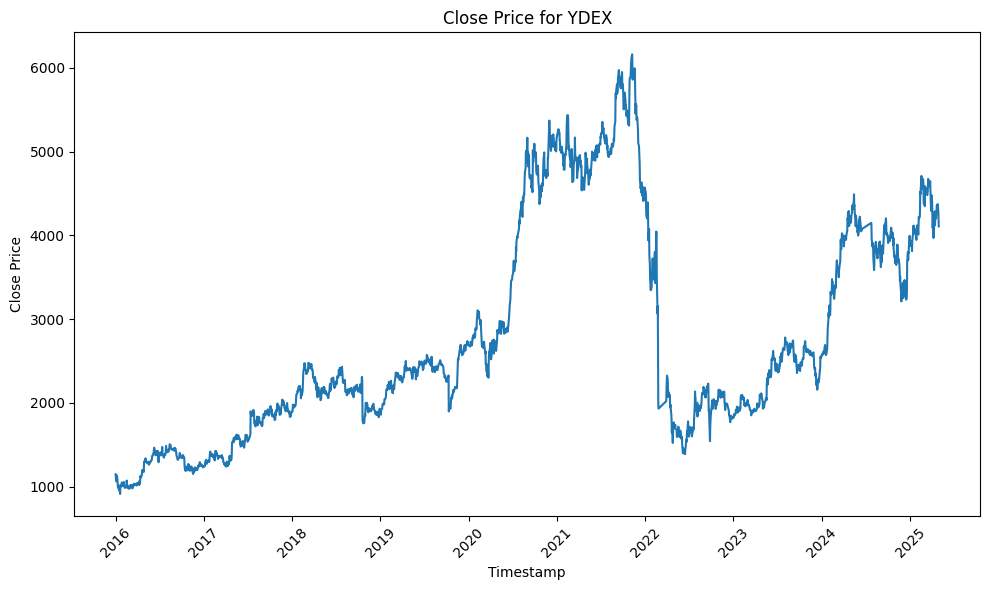

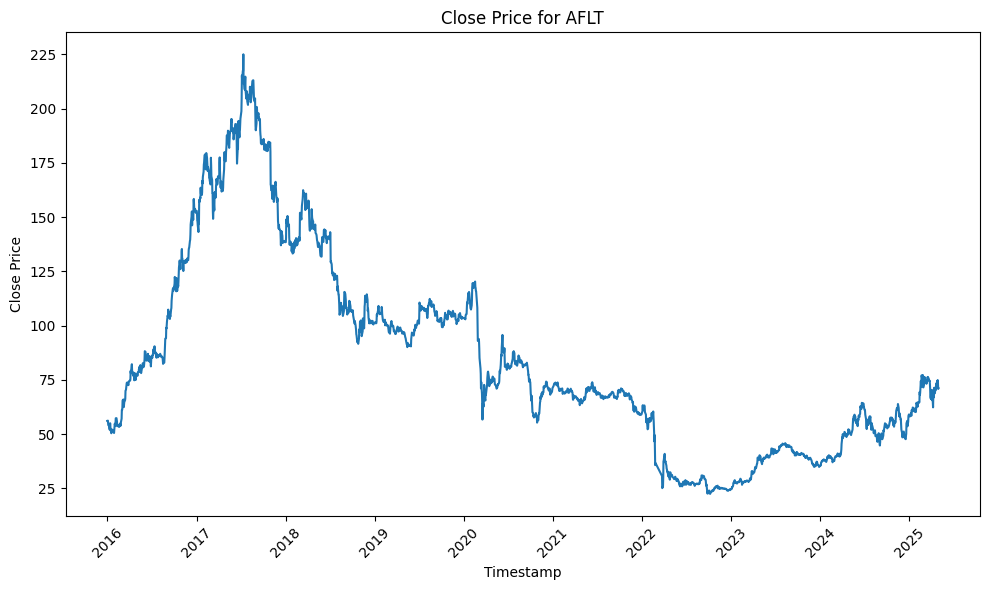

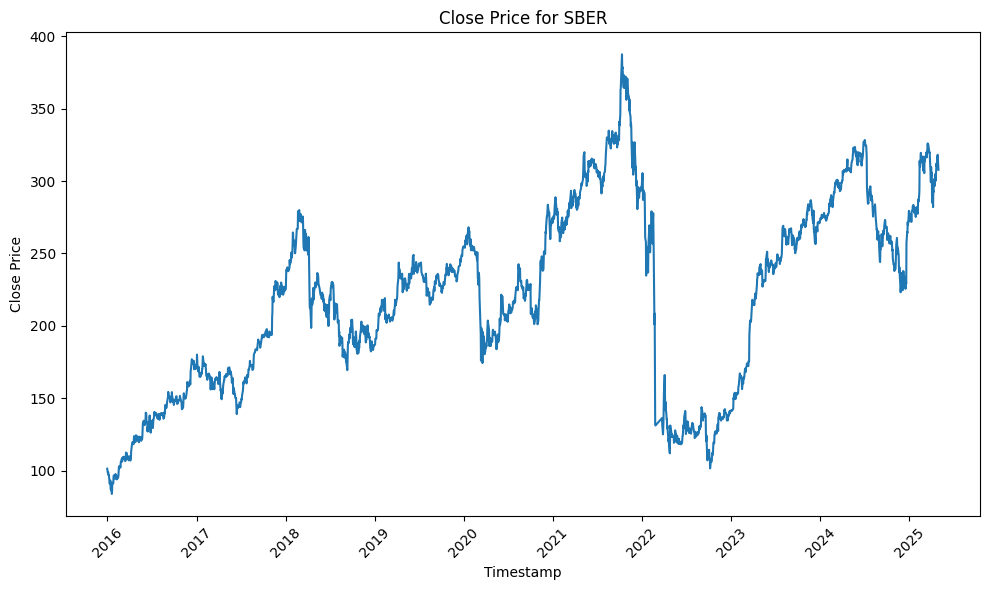

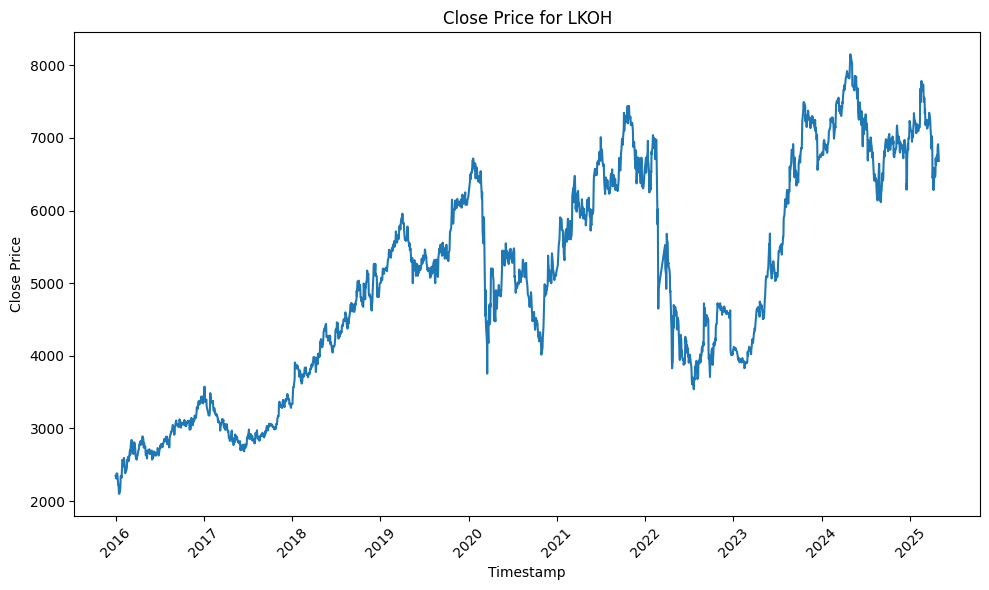

In [32]:
for ticker, data in df.items():
    plt.figure(figsize=(10, 6))
    plt.plot(data['timestamp'], data['close'])
    plt.title(f'Close Price for {ticker}')
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Сохранение данных

In [33]:
def export_series_to_csv(df_dict, output_dir='../data'):
    """
    Сохраняет каждый DataFrame из словаря df_dict в отдельный CSV файл с именем series_{ticker}.csv

    Args:
        df_dict (dict): Словарь {ticker: DataFrame}.
        output_dir (str): Путь к папке для сохранения файлов.
    """
    os.makedirs(output_dir, exist_ok=True)

    for ticker, df_ticker in df_dict.items():
        filepath = os.path.join(output_dir, f'series_{ticker}.csv')
        df_ticker.to_csv(filepath, index=False)
        print(f"✔ Saved: {filepath}")

In [34]:
export_series_to_csv(df)

✔ Saved: ../data/series_VKCO.csv
✔ Saved: ../data/series_VTBR.csv
✔ Saved: ../data/series_X5.csv
✔ Saved: ../data/series_NVTK.csv
✔ Saved: ../data/series_MOEX.csv
✔ Saved: ../data/series_PIKK.csv
✔ Saved: ../data/series_YDEX.csv
✔ Saved: ../data/series_AFLT.csv
✔ Saved: ../data/series_SBER.csv
✔ Saved: ../data/series_LKOH.csv
